**Word embeddings**

In this exercise we will experiment with natural language processing using word embeddings. Later, we will attempt at part-of-speech classification, using the word vectors themselves as feature vectors.

After completing this notebook, please copy the following into your PDF report:

* a frequency histogram, and a histogram of the co-occurances of the words in the dataset
* the list of the 10 most frequent words, and the 10 least frequent words
* the list of the 10 most cooccuring word pairs
* the 10 closest words to the city where you were born. (If you were born in a town which is not in the vocabulary, pick the closest city which *is* in the vocabulary.
* the 10 closest words to an object that is close to you right now.
* your 2-D PCA word embeddings, and some comments on any interesting geometric structure you may see


In [8]:
# import packages (may take some time)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py
import scipy.sparse.linalg as ssl
import nltk
nltk.download('universal_tagset')
import scipy.sparse as ss

plt.style.use('tableau-colorblind10')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /users2/avirinchipur/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


**Data**

The following files are some counts matrices/vectors that were accrued by scraping the wikipedia dataset, archived from 2000 (enwiki 2000). They have already been preprocessed somewhat; namely

* all "stopwords", or words that are far too common (see stopwords.txt) have been removed
* rare words (occuring fewer than 10000 times in the corpus) have been removed

Use at least 100 bins in your histogram, to really see the distribution. Remember to set the minimum bin range to be 10000, or you will have a huge spike at 0.

Take a look at these files, and plot a histogram of the word frequencies, and the cooccurance numbers. Note that these figures are actually *less* sharp than it would be over a non-preprocessed corpus.

In [2]:

f = h5py.File('../data/cooccurance_stop0_minfreq10000_skipwindow5.mat')
cooccurance = np.array(f['wordcontext'])
wordfreq = sio.loadmat('../data/wordfreq_update.mat')
freq = wordfreq['freq'][0,:].astype(float)
wordlist = wordfreq['word'][0,:]
wordlist = [word[0] for word in wordlist]



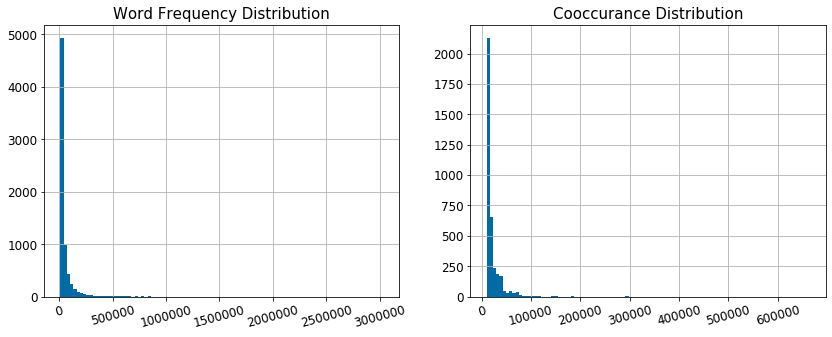

In [22]:
cooccurance_no_dup = np.triu(cooccurance, 1).flatten()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist(freq, bins=100, range = (10000, freq.max()))
axs[0].set_title("Word Frequency Distribution", fontsize=15)
axs[0].grid(which="both")
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].tick_params(axis="x",  labelrotation=15)

axs[1].hist(cooccurance_no_dup, bins=100, range = (10000, cooccurance_no_dup.max()))
axs[1].set_title("Cooccurance Distribution", fontsize=15)
axs[1].grid(which="both")
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis="x",  labelrotation=15)

plt.show()
fig.savefig(f"./word_dist.png", bbox_inches="tight", pad_inches=0.5)

**Stats**

Play around with these statistics. Print out
* the 10 most frequent and least frequent words
* the 10 most frequent pairs of words. (Be sure to get rid of repeated words and pairs that occur twice (a,b) = (b,a))

In [23]:
# Most and Least frequent words
word_freq = sorted(list(zip(wordlist, freq)), key=lambda x: x[1])
print (f"10 most frequent words: {np.array(word_freq[-10:])[:, 0].tolist()}")
print (f"10 least frequent words: {np.array(word_freq[:10])[:, 0].tolist()}")

10 most frequent words: ['national', 'state', 'united', 'made', 'world', 'city', 'school', 'years', 'time', 'endofdocument']
10 least frequent words: ['afc', 'consumed', 'remake', 'eighteenth', 'sinking', 'coronation', 'suited', 'factions', 'explicit', 'reside']


In [25]:
# Most frequent word pairs
cooccurance_no_dup = np.triu(cooccurance, 1)
most_frequent_pairs = np.unravel_index(np.argsort(cooccurance_no_dup, axis=None), cooccurance.shape)

In [26]:
np.array(cooccurance_no_dup, dtype=int)

array([[   0,    1,    1, ...,   15,    0,    1],
       [   0,    0,    2, ...,    9,    5,    1],
       [   0,    0,    0, ...,    3,    3,    1],
       ...,
       [   0,    0,    0, ...,    0, 1772,   16],
       [   0,    0,    0, ...,    0,    0,   11],
       [   0,    0,    0, ...,    0,    0,    0]])

In [28]:
#Most frequent word pairs
freq_coocc_words = [(wordlist[i], wordlist[j]) for i, j in list(zip(most_frequent_pairs[0][-10: ], most_frequent_pairs[1][-10: ]))]
print(freq_coocc_words)

[('females', 'median'), ('age', 'females'), ('album', 'released'), ('females', 'males'), ('males', 'median'), ('war', 'world'), ('income', 'median'), ('age', 'years'), ('high', 'school'), ('states', 'united')]


In [29]:
for i, j in freq_coocc_words:
    print (f"{i}, {j}")

females, median
age, females
album, released
females, males
males, median
war, world
income, median
age, years
high, school
states, united


**PPMI matrix**

Now construct a PPMI matrix defined as follows

$$PMI_{ij} = \log\left(\frac{corpus size \cdot coocurrance_{ij}}{ (freq(i)\cdot freq(j) + 1.)}\right), \qquad PPMI = \max\{PMI,0\}$$

(here, the + 1 is used to prevent dividing by 0)

Form word embeddings of dimension 300 by taking the eigenvalue decomposition of PPMI and removing the eigenvalue/eigenvector pairs which are not amongst the largest 300 eigenvalues. Then form the factorization as 

$$PPMI = U D U^T, \qquad V = UD^{1/2}$$

Hold onto these vectors $V$; they will later be your feature vectors (for each word, a feature vector of length 300)

In [30]:
#pmi = np.log(cooccurance*sum(freq))/(freq)/((freq+1).reshape(-1,1))
pmi = np.log(cooccurance*sum(freq)/(np.dot(freq.reshape(-1,1), freq.reshape(1, -1)) + 1))
ppmi = pmi
ppmi[ppmi < 0] = 0
ppmi.max(), ppmi.min()

(10.427018572058955, 0.0)

In [31]:
#Takes very long
w, u = np.linalg.eig(ppmi)

In [32]:
np.sum(np.isnan(u)), np.sum(np.isnan(w))

(0, 0)

In [33]:
dims_req = np.argsort(w)[-300:]
v = np.dot(u[:, dims_req], (np.diag(np.sqrt(w[dims_req]))))

In [34]:
v.shape

(7141, 300)

**Nearest K words**

For fun, let's take a look at the geometry of these words! Create a function that returns the "k closest words" via cosine similarity:

$$cossim(word_i, word_j) = \frac{v_i^Tv_j}{\|v_i\|_2\|v_j\|}$$

That is, given a word, find the 10 words with the highest cossim with the query word.

In [37]:
def get_k_closest_words(word, k):
    if word not in wordlist: return "Word not in the vocab"

    word_idx = wordlist.index(word)
    word_vec = v[word_idx]
    cossim_nr = np.dot(v, word_vec.reshape(-1, 1))
    cossim_dr = (np.sqrt(np.sum(v**2, axis=1)*np.sum(word_vec**2))).reshape(-1,1) + np.finfo(float).eps

    cossim = cossim_nr/cossim_dr
    closest_word_idx = np.argsort(cossim.reshape(-1,))

    #closest_word_idx = closest_word_idx[closest_word_idx!=word_idx]
    print (cossim[closest_word_idx[-k-1:]])
    return reversed(closest_word_idx[-k-1:])

print ([wordlist[i] for i in get_k_closest_words('shanghai',10)])
print ([wordlist[i] for i in get_k_closest_words('coffee',10)])

print ([wordlist[i] for i in get_k_closest_words('mumbai',10)])
print ([wordlist[i] for i in get_k_closest_words('phone',10)])

[[0.47472587]
 [0.52714591]
 [0.53202943]
 [0.53356318]
 [0.54614651]
 [0.559744  ]
 [0.61407751]
 [0.63529669]
 [0.65355523]
 [0.66046847]
 [1.        ]]
['shanghai', 'beijing', 'hong', 'kong', 'china', 'chinese', 'tokyo', 'taiwan', 'seoul', 'singapore', 'korea']
[[0.51764326]
 [0.52107321]
 [0.52692603]
 [0.52870225]
 [0.53328615]
 [0.53878728]
 [0.54082816]
 [0.56970574]
 [0.58974351]
 [0.68394609]
 [1.        ]]
['coffee', 'tea', 'sugar', 'drink', 'tobacco', 'vegetables', 'fruit', 'milk', 'food', 'cream', 'corn']
[[0.50561572]
 [0.52195618]
 [0.54352501]
 [0.54980036]
 [0.55007385]
 [0.58407105]
 [0.59274131]
 [0.6255775 ]
 [0.67898175]
 [0.73459574]
 [1.        ]]
['mumbai', 'delhi', 'bombay', 'india', 'pradesh', 'kerala', 'karnataka', 'nadu', 'tamil', 'punjab', 'bengal']
[[0.53324194]
 [0.53821602]
 [0.538653  ]
 [0.55886391]
 [0.56634182]
 [0.59405192]
 [0.59892534]
 [0.601626  ]
 [0.62109157]
 [0.76108229]
 [1.        ]]
['phone', 'telephone', 'email', 'internet', 'calls', 'wir

**Visualization**

To make some pretty plots, do a PCA on your word embedding. First normalize by setting the mean word embedding to 0. Then extract the largest 2 eigenvalue/eigenvector pairs, and plot them. 

The plot itself gets a bit overwhelming if you try to plot all the words at once. Instead, pick some fun word, and plot the 100 words closest too it, using your previous code. (Use plt.text to plot the texts in 2-D space.)

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components=2)
v_norm = v - np.mean(v, axis=0)
v_norm_pca = pca.fit_transform(v_norm)
print (v_norm_pca.shape)

(7141, 2)


[[0.35239449]
 [0.35259553]
 [0.35355462]
 [0.35397233]
 [0.35689308]
 [0.35696448]
 [0.35851042]
 [0.3587142 ]
 [0.35975405]
 [0.36005462]
 [0.3601115 ]
 [0.36038163]
 [0.36255078]
 [0.36355748]
 [0.36441673]
 [0.36452327]
 [0.36480289]
 [0.36594589]
 [0.36607107]
 [0.36661615]
 [0.36709435]
 [0.36729418]
 [0.36951115]
 [0.37073302]
 [0.37411221]
 [0.37444313]
 [0.37448609]
 [0.37583887]
 [0.37588089]
 [0.37624583]
 [0.37632158]
 [0.37671197]
 [0.37789318]
 [0.37905141]
 [0.37981971]
 [0.38144535]
 [0.38201304]
 [0.38353492]
 [0.38395582]
 [0.38589497]
 [0.38772111]
 [0.38939064]
 [0.38969367]
 [0.39033965]
 [0.39163251]
 [0.39306095]
 [0.39357416]
 [0.39583119]
 [0.39662173]
 [0.39689447]
 [0.40002978]
 [0.40016298]
 [0.40157605]
 [0.40275588]
 [0.40810929]
 [0.40865673]
 [0.40871645]
 [0.40904636]
 [0.41049658]
 [0.41180093]
 [0.41192895]
 [0.41350898]
 [0.41492644]
 [0.41581757]
 [0.41670234]
 [0.4246536 ]
 [0.42844833]
 [0.43384132]
 [0.43565922]
 [0.44880311]
 [0.45502375]
 [0.45

<Figure size 720x720 with 0 Axes>

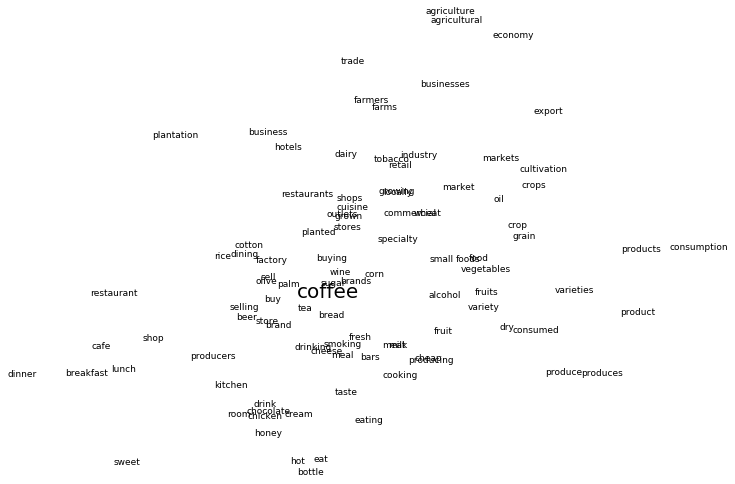

In [44]:
plot_words = get_k_closest_words('coffee', 100)
print (plot_words)

vec_pca = v_norm_pca*1
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax.axis("off")

for k in plot_words:
    if wordlist[k] != "coffee": 
        plt.text(vec_pca[k,0],vec_pca[k,1], wordlist[k], fontsize=9)
    else:
        plt.text(vec_pca[k,0],vec_pca[k,1], wordlist[k], fontsize=20)

plt.show()    
fig.savefig(f"word_space.png", bbox_inches="tight", pad_inches=0.5)

**Part of speech label**

Finally, we use an online POS tagger to label our words. We will then save everything into a dataset, which we can then use for some fun machine learning tasks!

Run the code given in the box.  Using the example, construct a train set (word embeddings) and test set (number representing part of speech), and save it somehow (using sio.savemat or pickle.dump). 

To verify that everything went correctly, the following is the counts per part-of-speech:

* NOUN 3654
* VERB 1678
* ADJ 1497
* ADV 254
* ADP 24
* NUM 4
* DET 1
* PRT 3
* X 23
* PRON 3


In [21]:
print (nltk.pos_tag(['I','really','need','my','coffee'],'universal'))



[('I', 'PRON'), ('really', 'ADV'), ('need', 'VERB'), ('my', 'PRON'), ('coffee', 'NOUN')]


**Form classification task**

We assign an ordering to the POS labels as

POS = [NOUN, VERB, ADJ, ADV, ADP, NUM, DET, PRT, X, PRON]

We will now create a classification problem by forming a V x d data matrix X matrix, which just contains the word embeddings,  and length V label vector y, which contains at each element a number k if that word has label POS[k]. We will additionally discard any labels where there are too few examples. Do this by running the following box, and using your own embedding matrix V. 


In [26]:

tag_label = nltk.pos_tag(wordlist,tagset='universal')
tag_label = [t[1] for t in tag_label]
unique_tags = []
for k in range(len(tag_label)):    
    if tag_label[k] not in unique_tags:
        unique_tags.append(tag_label[k])

print (unique_tags)
unique_tags = [u for u in unique_tags if len([t for t in tag_label if t == u]) > 20]

for u in   unique_tags:
    print (u, len([t for t in tag_label if t == u]))
    
        
for k in range(len(tag_label)):    
    if tag_label[k] in unique_tags:
        tag_label[k] = unique_tags.index(tag_label[k])
        if k < 10:
            print (unique_tags[tag_label[k]], tag_label[k], len([t for t in tag_label if t == tag_label[k]]))
    else: tag_label[k] = -1

tag_label = np.array(tag_label) 
keep = np.greater(tag_label,-1)


sio.savemat('../data/word_pos_data.mat',{'word_emb':v[keep,:],'word_label':np.array(tag_label[keep])})

['NOUN', 'VERB', 'ADJ', 'ADV', 'ADP', 'NUM', 'DET', 'PRT', 'X', 'PRON']
NOUN 3653
VERB 1678
ADJ 1498
ADV 254
ADP 24
X 23
NOUN 0 1
NOUN 0 2
NOUN 0 3
VERB 1 1
ADJ 2 1
ADV 3 1
VERB 1 2
NOUN 0 4
NOUN 0 5
ADJ 2 2
